<h1>Gamma Delta T-cells</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
if os.path.isfile('algo_times.csv'):
    performance = pd.read_csv('algo_times.csv').to_dict('list')
else:
    performance = dict(sample_id=[], task=[], method=[], time_seconds=[])

In [4]:
def timed_apply(sample_go, task_name, gate_name, performance_record, plot=True, save=True):
    start = datetime.now()
    sample_go.apply(gate_name, plot_output=plot)
    end = datetime.now()
    performance['sample_id'].append(sample_go.id)
    performance['method'].append(gate_name)
    performance['time_seconds'].append((end-start).total_seconds())
    performance['task'].append(task_name)
    if save:
        pd.DataFrame(performance).to_csv('algo_times.csv', index=False)
    return performance_record

In [5]:
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [6]:
def visualise_manual_ellipse(sample_go, population, x, y, centroid, width, height, angle, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(population)[[x, y]], features_to_transform=[x,y],
                           transform_method='logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

<h2>Manual Gating</h2>

In [18]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [19]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [208]:
hc = Gating(exp, 'hc4')

In [209]:
for x in ['manual_gdt', 'manual_nongdt', 'manual_vd2Neg']:
    if x in hc.gates.keys():
        hc.gates.pop(x)

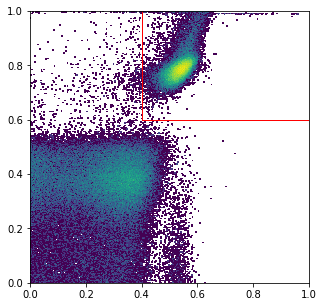

In [210]:
x_min, x_max, y_min, y_max = 0.4, 1.0, 0.6, 1.0
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [211]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_gdt', definition='+')
child_populations.add_population('manual_gdtNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_gdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

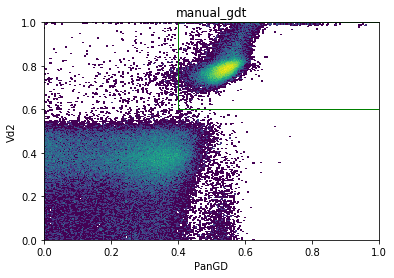

In [212]:
hc.apply('manual_gdt')

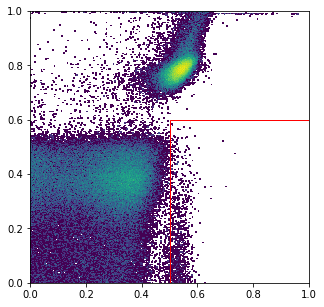

In [213]:
x_min, x_max, y_min, y_max = 0.5, 1.0, 0, 0.6
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [214]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_vd2Neg', definition='+')
child_populations.add_population('manual_vd2NegNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_vd2Neg', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

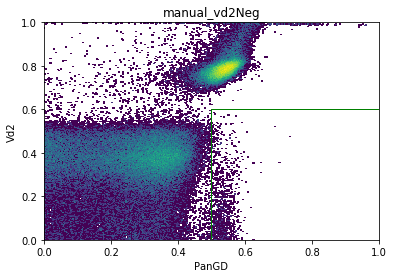

In [215]:
hc.apply('manual_vd2Neg')

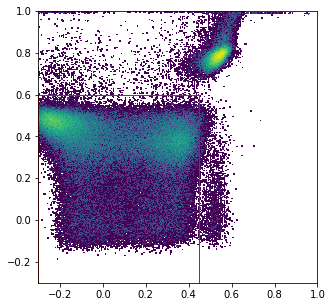

In [217]:
x_min, x_max, y_min, y_max = -0.3, 0.75, -0.3, 0.9
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(-0.3,1), ylim=(-0.3,1))

In [218]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_nongdt', definition='+')
child_populations.add_population('manual_nongdtNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_nongdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

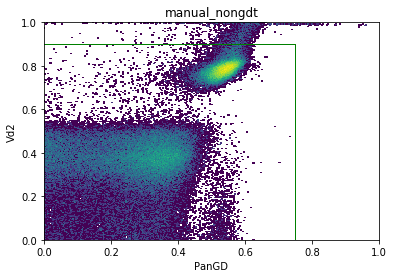

In [219]:
hc.apply('manual_nongdt')

In [220]:
hc.save(overwrite=True)

Saved successfully!


True

<h2>Automated Gates</h2>

In [9]:
hc = Gating(exp, 'hc1')

<h3>Mixture model</h3>

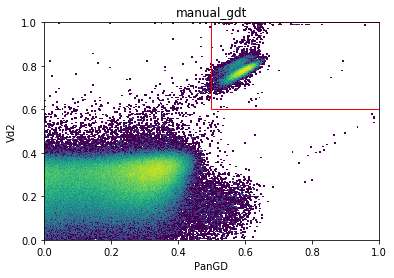

In [9]:
hc.plotting.plot_gate('manual_gdt')

In [10]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_gdt', definition='+')
child_populations.add_population('gmm_gdtNEG', definition='-')

pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

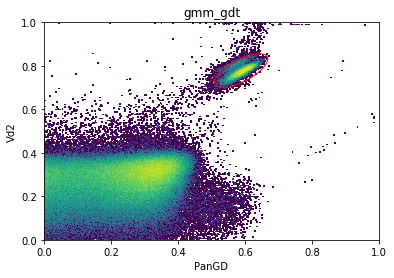

In [11]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=False)

In [12]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_vd2Neg', definition='+')
child_populations.add_population('gmm_vd2NegNEG', definition='-')

pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0, ymax=0.6)
gate_definition = dict(x='PanGD', y='Vd2', target=[0.5, 0.2], conf=0.95, rect_filter=pre_filter,
                      k=2)
hc.create_gate(gate_name='gmm_vd2Neg', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

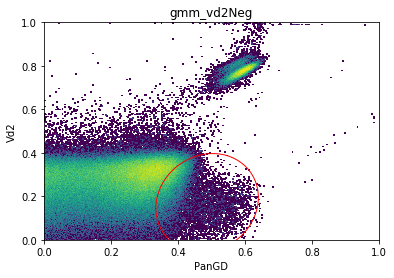

In [13]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_vd2Neg',
                          performance_record=performance, save=False)

In [14]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_nongdt', definition='+')
child_populations.add_population('gmm_nongdtNEG', definition='-')

pre_filter=dict(xmin=0, xmax=0.5, ymin=0, ymax=0.6)
gate_definition = dict(x='PanGD', y='Vd2', target=[0.2, 0.2], conf=0.95, rect_filter=pre_filter,
                      k=2)
hc.create_gate(gate_name='gmm_nongdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

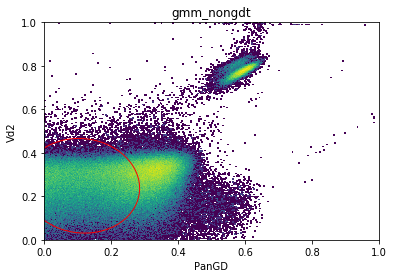

In [15]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_nongdt',
                          performance_record=performance, save=False)

<h3>DBSCAN</h3>

In [16]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

sampling_kwargs = dict()
gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                      downsample_method='density', frac=0.2)
hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
               method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

Expected 3 populations, identified 4; {0, 1, 2, 3, -1}
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.


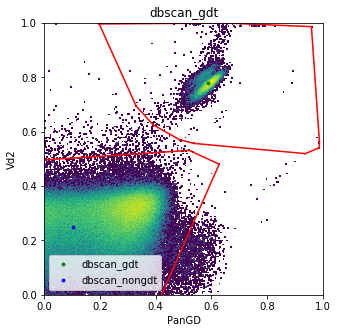

In [17]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=False)

<img src='clever.jpg'>

<h3>HDBSCAN</h3>

In [18]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

sampling_kwargs = dict()
gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
               method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 0;prioritising hdbscan_nongdt based on weighting.


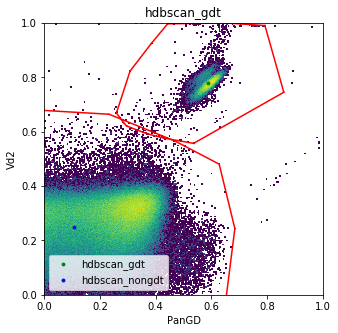

In [19]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                          performance_record=performance, save=False)

<h3>2D Density Threshold</h3>

In [23]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_gdt', definition=['++'])
child_populations.add_population('dens2d_nongdt', definition=['--'])
child_populations.add_population('dens2d_vd2', definition=['-+'])
child_populations.add_population('dens2d_noise', definition=['+-'])
gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

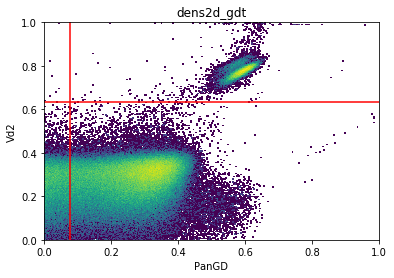

In [24]:
performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=False)

In [8]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [9]:
for x in samples[1:]:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    
    print('mixture model...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')

    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    sampling_kwargs = dict()
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                              performance_record=performance, save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=True, plot=False)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

Gating hc4...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 1;prioritising dbscan_nongdt based on weighting.
hdbscan...
Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 3;prioritising hdbscan_nongdt based on weighting.
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc5...
mixture model...
dbscan...
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
hdbscan...
Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 3;prioritising hdbscan_nongdt based on weighting.
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc7...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_gdt', 'dbscan

<h3>Solving DBSCAN cluster assignment error</h3>

In [8]:
hc = Gating(exp, 'hc7')

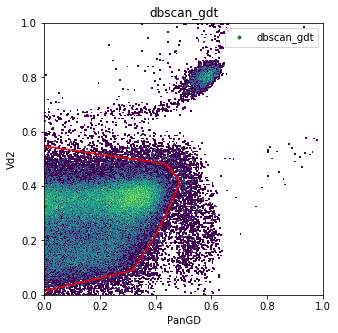

In [9]:
hc.plotting.plot_gate('dbscan_gdt')

In [10]:
from immunova.flow.gating.transforms import apply_transform
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [11]:
from sklearn.neighbors import KDTree
import numpy as np
from functools import partial

In [12]:
def prob_downsample(local_d, target_d, outlier_d):
    if local_d <= outlier_d:
        return 0
    if outlier_d < local_d <= target_d:
        return 1
    if local_d > target_d:
        return target_d / local_d

In [13]:
features = ['PanGD', 'Vd2']
outlier_dens = 1
target_dens=5
df = data.copy()
mmd_sample = df.sample(2000)
tree = KDTree(mmd_sample[features], metric='manhattan')
dist, _ = tree.query(mmd_sample[features], k=2)
dist = np.median([x[1] for x in dist])
dist_threshold = dist * 5
ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
od = np.percentile(ld, q=outlier_dens)
td = np.percentile(ld, q=target_dens)
prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
prob = list(map(lambda x: prob_f(x), ld))

In [14]:
sampled = df.sample(frac=0.2, weights=prob)

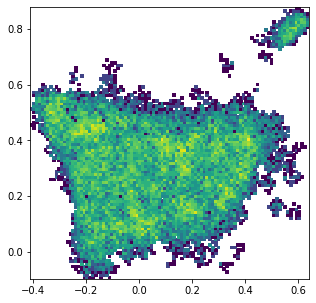

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

In [16]:
hc = Gating(exp, 'hc9')

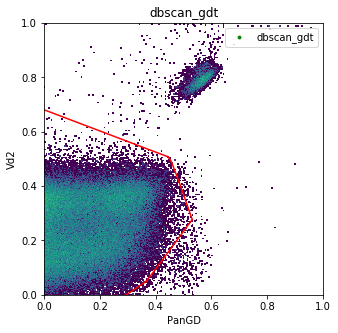

In [17]:
hc.plotting.plot_gate('dbscan_gdt')

In [18]:
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [19]:
features = ['PanGD', 'Vd2']
outlier_dens = 1
target_dens=5
df = data.copy()
mmd_sample = df.sample(2000)
tree = KDTree(mmd_sample[features], metric='manhattan')
dist, _ = tree.query(mmd_sample[features], k=2)
dist = np.median([x[1] for x in dist])
dist_threshold = dist * 5
ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
od = np.percentile(ld, q=outlier_dens)
td = np.percentile(ld, q=target_dens)
prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
prob = list(map(lambda x: prob_f(x), ld))

In [20]:
sampled = df.sample(frac=0.2, weights=prob)

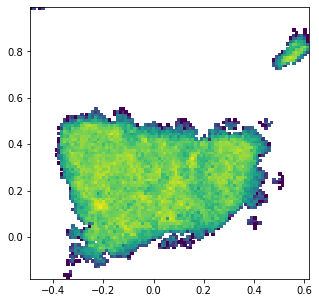

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

In [39]:
hc = Gating(exp, 'hc16')

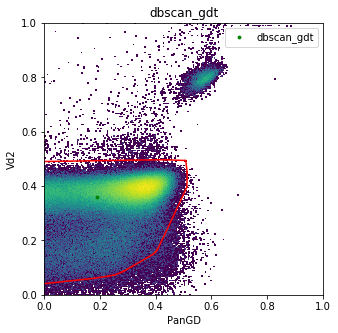

In [40]:
hc.plotting.plot_gate('dbscan_gdt')

In [41]:
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [42]:
features = ['PanGD', 'Vd2']
outlier_dens = 1
target_dens=5
df = data.copy()
mmd_sample = df.sample(2000)
tree = KDTree(mmd_sample[features], metric='manhattan')
dist, _ = tree.query(mmd_sample[features], k=2)
dist = np.median([x[1] for x in dist])
dist_threshold = dist * 5
ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
od = np.percentile(ld, q=outlier_dens)
td = np.percentile(ld, q=target_dens)
if td == 0:
    while td == 0:
        target_dens = target_dens + 0.05
        td = np.percentile(ld, q=target_dens)
prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
prob = list(map(lambda x: prob_f(x), ld))

In [43]:
dens_sampled = data.sample(frac=0.2, weights=prob)

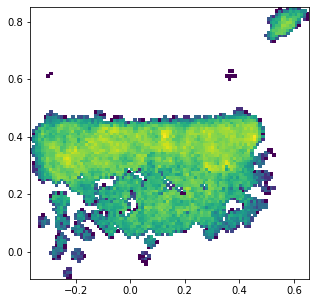

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(dens_sampled['PanGD'], dens_sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

Can conclude that density dependent downsampling still shows good representation of gamma delta t cells. I also know that density dependent downsampling is beneficial because looking at the same plot as above but sampled uniformally gives a far smaller gamma delta population:

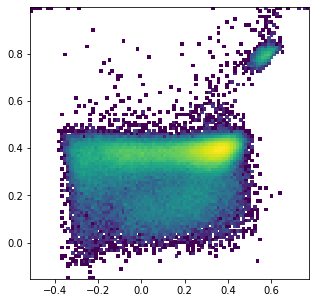

In [28]:
sampled = df.sample(frac=0.2)
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sampled['PanGD'], sampled['Vd2'], bins=100, norm=LogNorm())
fig.show()

Let's run through what the dbscan algorithm would dousing the density dependent downsample from HC16

<h3>Troubleshooting DBSCAN algo with HC16</h3>

In [227]:
from immunova.flow.gating.utilities import centroid
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.spatial import ConvexHull
from itertools import cycle
import numpy as np
import collections
import hdbscan
data = data.copy()
sample = dens_sampled.copy()

In [231]:
nn = 5
knn_model = KNeighborsClassifier(n_neighbors=nn, weights='distance', n_jobs=-1)

In [232]:
model = DBSCAN(eps=0.02,
               min_samples=100,
               algorithm='ball_tree',
               n_jobs=-1)

In [233]:
model.fit(sample[['PanGD', 'Vd2']])

DBSCAN(algorithm='ball_tree', eps=0.02, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [234]:
set(model.labels_)

{-1, 0, 1, 2}

In [235]:
sample['labels'] = model.labels_

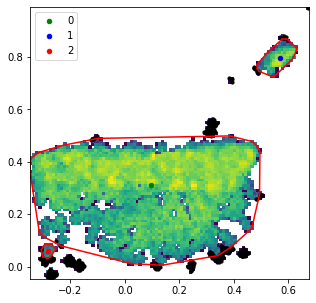

In [236]:
# Plot identified clusters in sampled data
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(sample['PanGD'], sample['Vd2'], bins=100, norm=LogNorm())
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(set(model.labels_), colours):
    if label == -1:
        noise = sample[sample['labels'] == -1][['PanGD', 'Vd2']].values
        ax.scatter(x=noise[:, 0], y=noise[:, 1], c='black', s=10)
        continue
    d = sample[sample['labels'] == label][['PanGD', 'Vd2']].values
    centroid_ = centroid(d)
    ax.scatter(x=centroid_[0], y=centroid_[1], s=20, c=colour, label=label)
    hull = ConvexHull(d)
    for simplex in hull.simplices:
        ax.plot(d[simplex, 0], d[simplex, 1], 'k-', c='red')
ax.legend()
fig.show()

Algorithm correctly identifies the clusters in the sampled data so cluster assignment must be at fault. Let's upsample using the KNN model and make sure the clusters are still correctly identified.

In [237]:
knn_model.fit(sample[['PanGD', 'Vd2']], model.labels_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')

In [238]:
data['labels'] = knn_model.predict(data[['PanGD', 'Vd2']])

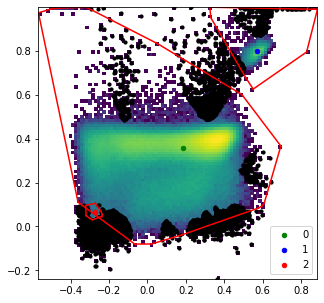

In [239]:
# Plot identified clusters in complete data
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(data['PanGD'], data['Vd2'], bins=100, norm=LogNorm())
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(set(model.labels_), colours):
    if label == -1:
        noise = data[data['labels'] == -1][['PanGD', 'Vd2']].values
        ax.scatter(x=noise[:, 0], y=noise[:, 1], c='black', s=10)
        continue
    d = data[data['labels'] == label][['PanGD', 'Vd2']].values
    centroid_ = centroid(d)
    ax.scatter(x=centroid_[0], y=centroid_[1], s=20, c=colour, label=label)
    hull = ConvexHull(d)
    for simplex in hull.simplices:
        ax.plot(d[simplex, 0], d[simplex, 1], 'k-', c='red')
ax.legend()
fig.show()

Less than ideal, the clusters spread much further than I would like and there is quite alot of overlap with noise. Let's try increasing the number of nearest neighbours.

In [240]:
nn = 50
knn_model = KNeighborsClassifier(n_neighbors=nn, weights='distance', n_jobs=-1)

In [241]:
knn_model.fit(sample[['PanGD', 'Vd2']], model.labels_)
data['labels'] = knn_model.predict(data[['PanGD', 'Vd2']])

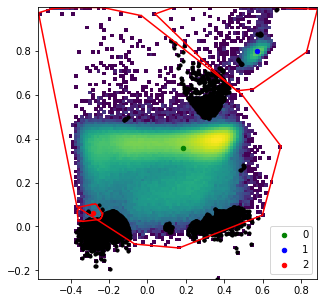

In [242]:
# Plot identified clusters in complete data
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(data['PanGD'], data['Vd2'], bins=100, norm=LogNorm())
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(set(model.labels_), colours):
    if label == -1:
        noise = data[data['labels'] == -1][['PanGD', 'Vd2']].values
        ax.scatter(x=noise[:, 0], y=noise[:, 1], c='black', s=10)
        continue
    d = data[data['labels'] == label][['PanGD', 'Vd2']].values
    centroid_ = centroid(d)
    ax.scatter(x=centroid_[0], y=centroid_[1], s=20, c=colour, label=label)
    hull = ConvexHull(d)
    for simplex in hull.simplices:
        ax.plot(d[simplex, 0], d[simplex, 1], 'k-', c='red')
ax.legend()
fig.show()

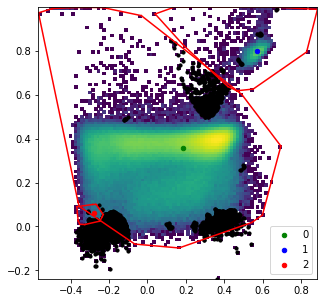

In [243]:
nn = 100
knn_model = KNeighborsClassifier(n_neighbors=nn, weights='distance', n_jobs=-1)
knn_model.fit(sample[['PanGD', 'Vd2']], model.labels_)
data['labels'] = knn_model.predict(data[['PanGD', 'Vd2']])

# Plot identified clusters in complete data
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(data['PanGD'], data['Vd2'], bins=100, norm=LogNorm())
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(set(model.labels_), colours):
    if label == -1:
        noise = data[data['labels'] == -1][['PanGD', 'Vd2']].values
        ax.scatter(x=noise[:, 0], y=noise[:, 1], c='black', s=10)
        continue
    d = data[data['labels'] == label][['PanGD', 'Vd2']].values
    centroid_ = centroid(d)
    ax.scatter(x=centroid_[0], y=centroid_[1], s=20, c=colour, label=label)
    hull = ConvexHull(d)
    for simplex in hull.simplices:
        ax.plot(d[simplex, 0], d[simplex, 1], 'k-', c='red')
ax.legend()
fig.show()

I can improve this by measuring the local density of noise (as identified by dbscan) in the sample. Then is data in the whole sample is below this local density threshold, they too shall be labelled as noise.

In [270]:
# Create a KDTree of sampled data
# For every cell in sampled data find the distance to its nearest neighbour
noise = sample[sample['labels'] == -1]
tree = KDTree(noise[['PanGD', 'Vd2']])
noise_dist, _ = tree.query(noise[['PanGD', 'Vd2']], k=10)

In [271]:
noise_dist = [np.mean(x[1:]) for x in noise_dist]
median_noise_dist = np.mean(noise_dist)

In [272]:
median_noise_dist

0.012258935075321852

In [278]:
tree = KDTree(data[['PanGD', 'Vd2']])
whole_dist, _ = tree.query(data[['PanGD', 'Vd2']], k=10)

In [279]:
whole_dist = [np.mean(x[1:]) for x in whole_dist]

In [280]:
data['distance'] = whole_dist
data['labels'] = np.where(data['distance'] >= median_noise_dist, -1, data['labels'])

In [281]:
data['labels'].unique()

array([ 0,  1, -1,  2])

So the average noise data point has about 2 neighbours. Now for the whole data label data points as noise if their local density is equal too or the average local density for noise in the sample when rounded up to the nearest integer.

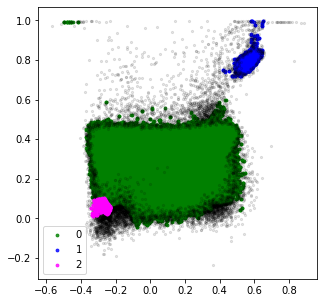

In [283]:
# Plot identified clusters in complete data
fig, ax = plt.subplots(figsize=(5,5))
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(data['labels'].unique(), colours):
    if label == -1:
        noise = data[data['labels'] == -1][['PanGD', 'Vd2']].values
        ax.scatter(x=noise[:, 0], y=noise[:, 1], c='black', s=5, alpha=0.1)
        continue
    d = data[data['labels'] == label][['PanGD', 'Vd2']].values
    ax.scatter(x=d[:,0], y=d[:,1], s=8, c=colour, label=label, alpha=0.8)
ax.legend()
fig.show()

That problem now appears to have been corrected. Note however: border gate should be run BEFORE EVERY GATE. This would solve the issue of the outliers in the top right and top left corners.

Still need to solve the issue of failed assignment of expected populations to clusters.

In [284]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

In [290]:
tree = KDTree(data[['PanGD', 'Vd2']])

In [289]:
child_populations.populations.keys()

dict_keys(['dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2'])

Assign dbscan_gdt to a cluster:

In [307]:
import collections
target = child_populations.populations['dbscan_gdt'].properties['target']
dist, ind = tree.query(np.array(target).reshape(1, -1), k=int(data.shape[0]*0.01))
neighbour_labels_counts = collections.Counter(data.iloc[ind[0]]['labels'].values).most_common()

In [308]:
neighbour_labels_counts

[(1, 6309), (-1, 21)]

The problem is, basing assignment on the most popular neighbour when K is so large results in incorrect assignment because larger populations dwarf smaller populations, even if the smaller population is closer.
To correct this the algorithm will be refactored as follows:
* If k neighbours are noise, where k is 1% of the total events, then target is associated to noise
* Otherwise, assign to the nearest centroid